In [16]:
from eval_lib import Evaluator, model_loader
from importlib import reload

In [38]:
import eval_lib
reload(eval_lib.evaluator)
from eval_lib.evaluator import Evaluator

In [39]:
epoch = 600

evaluator = Evaluator()
for i in range(24):
 print(evaluator.add_model(f'trained/transformer_wavelet/{i}', epoch, model_loader.load_transformer, i))

{'src_size': 15, 'tgt_size': 15, 'd_model': 64, 'num_heads': 2, 'num_layers': 2, 'd_ff': 128, 'max_seq_length': 24, 'dropout': 0.01}
{'src_size': 15, 'tgt_size': 15, 'd_model': 64, 'num_heads': 4, 'num_layers': 2, 'd_ff': 128, 'max_seq_length': 24, 'dropout': 0.01}
{'src_size': 15, 'tgt_size': 15, 'd_model': 64, 'num_heads': 2, 'num_layers': 4, 'd_ff': 128, 'max_seq_length': 24, 'dropout': 0.01}
{'src_size': 15, 'tgt_size': 15, 'd_model': 64, 'num_heads': 4, 'num_layers': 4, 'd_ff': 128, 'max_seq_length': 24, 'dropout': 0.01}
{'src_size': 15, 'tgt_size': 15, 'd_model': 64, 'num_heads': 2, 'num_layers': 2, 'd_ff': 256, 'max_seq_length': 24, 'dropout': 0.01}
{'src_size': 15, 'tgt_size': 15, 'd_model': 64, 'num_heads': 4, 'num_layers': 2, 'd_ff': 256, 'max_seq_length': 24, 'dropout': 0.01}
{'src_size': 15, 'tgt_size': 15, 'd_model': 64, 'num_heads': 2, 'num_layers': 4, 'd_ff': 256, 'max_seq_length': 24, 'dropout': 0.01}
{'src_size': 15, 'tgt_size': 15, 'd_model': 64, 'num_heads': 4, 'num_

600
120


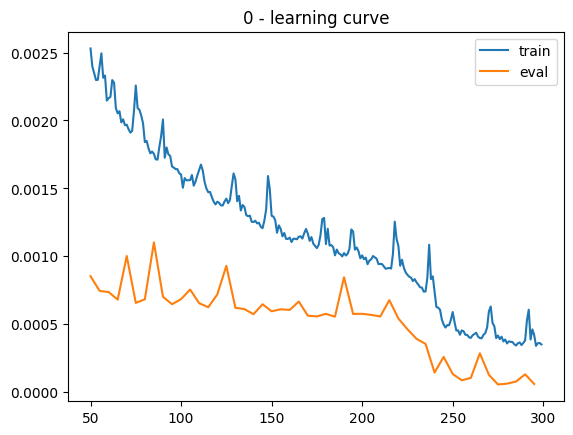

600
120


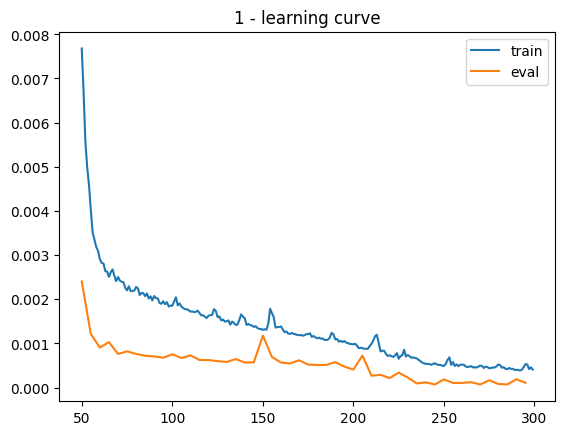

600
120


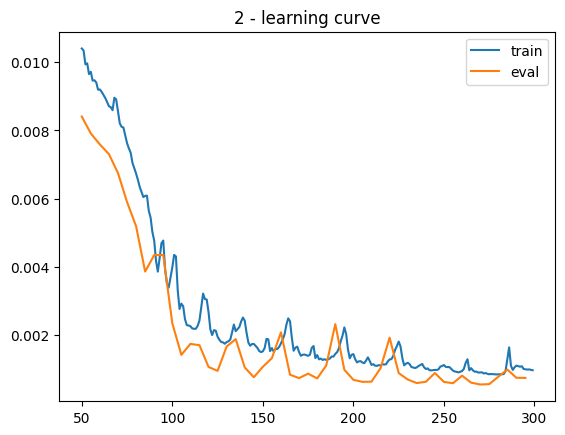

600
120


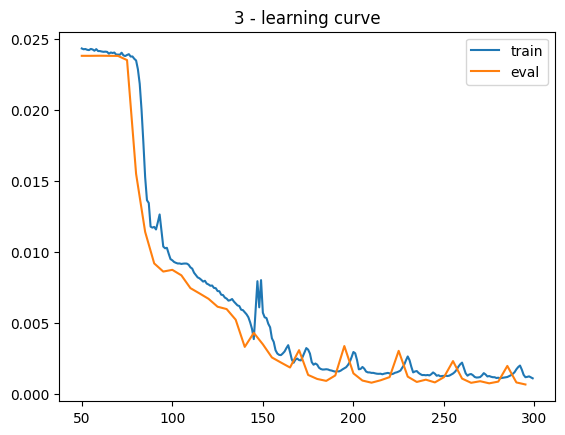

600
120


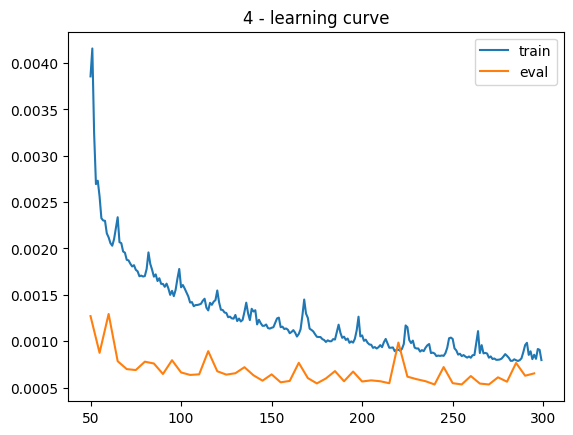

600
120


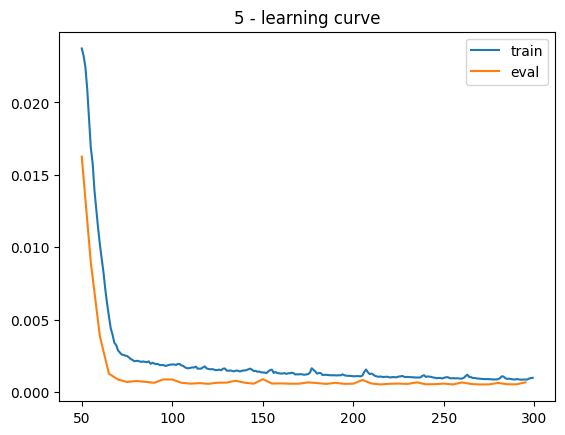

600
120


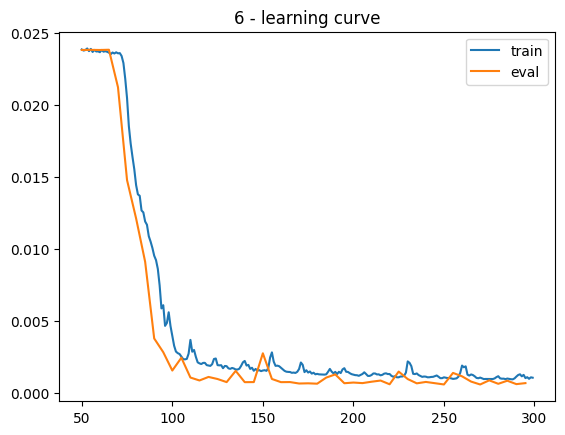

600
120


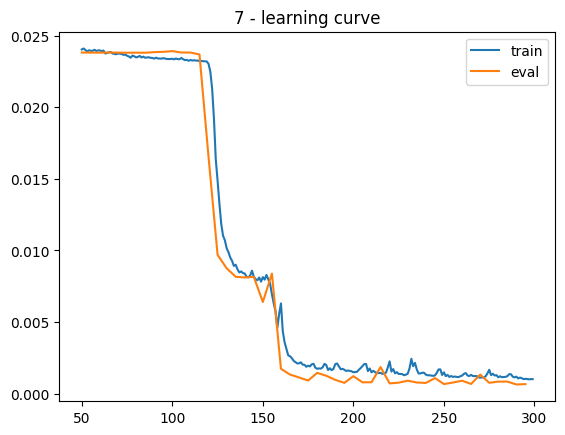

600
120


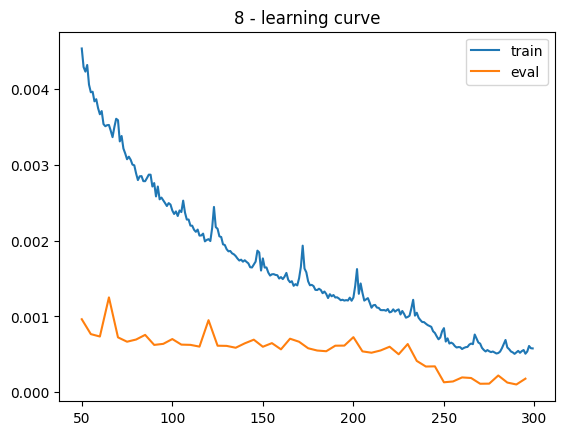

600
120


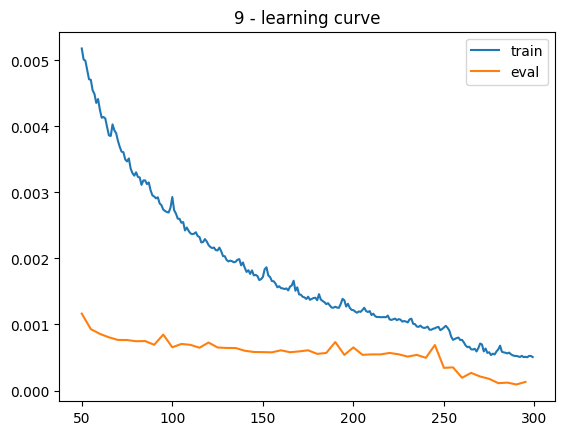

600
120


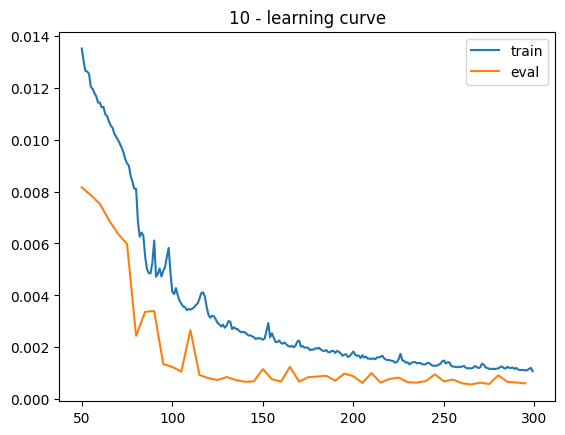

600
120


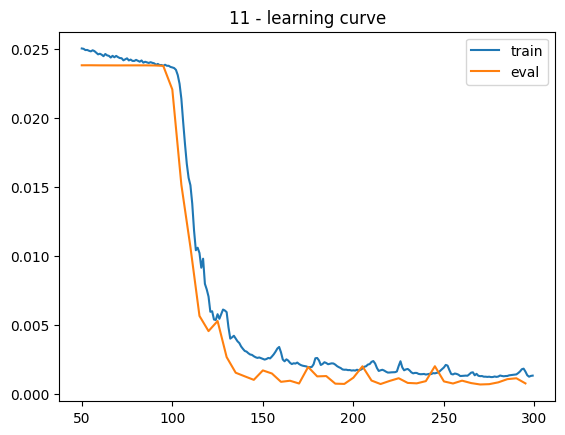

600
120


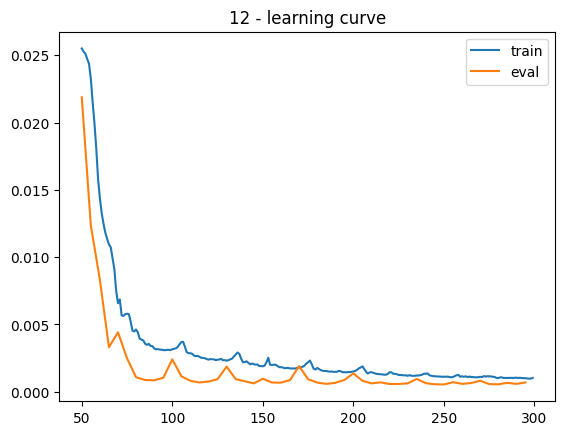

600
120


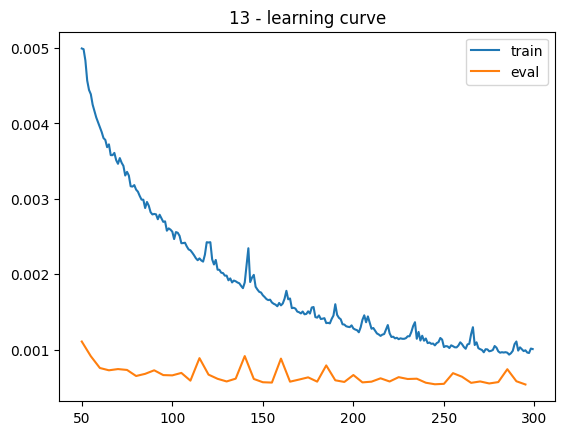

600
120


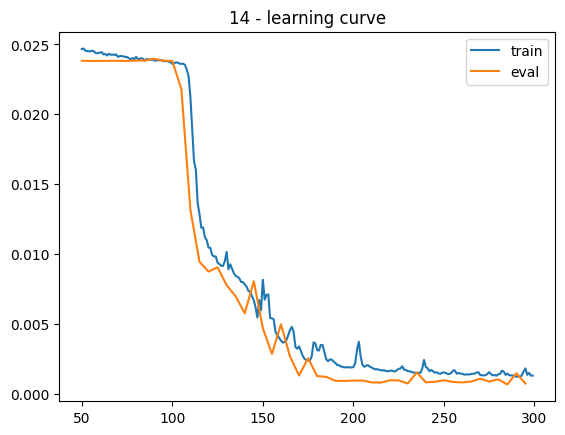

600
120


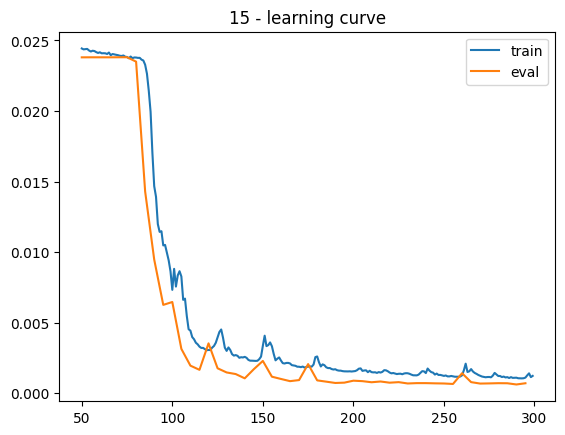

600
120


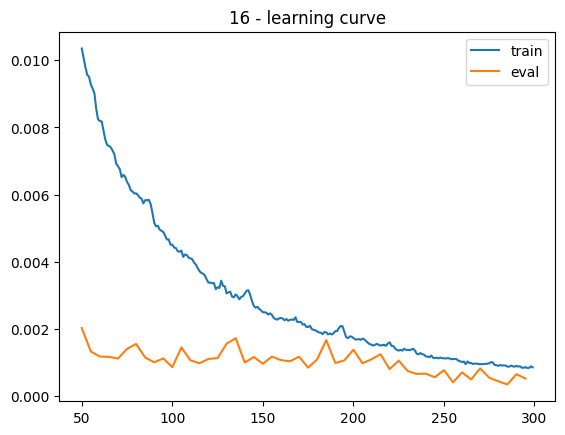

600
120


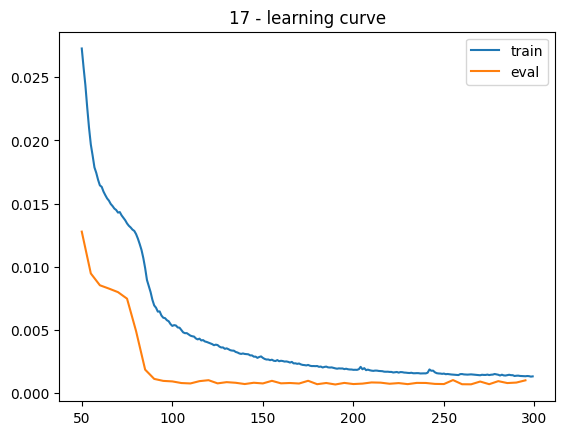

600
120


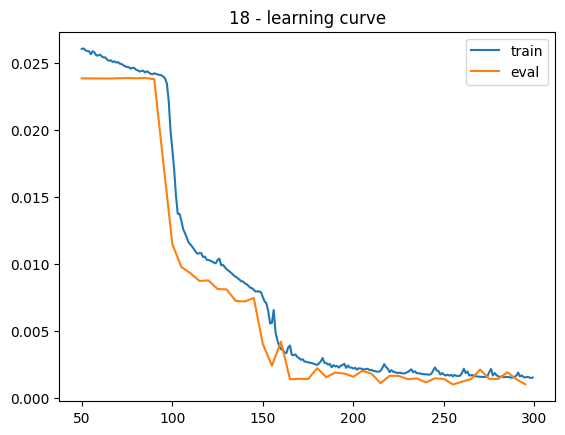

600
120


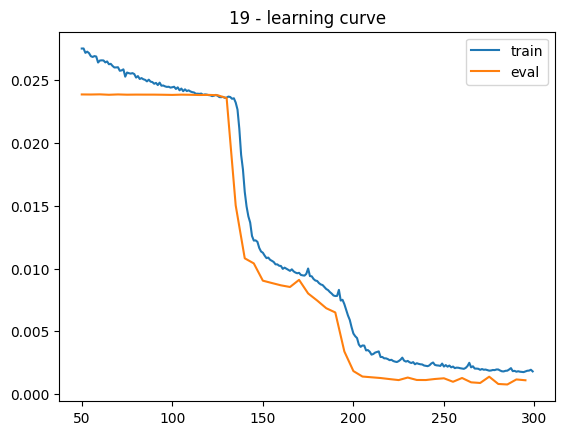

600
120


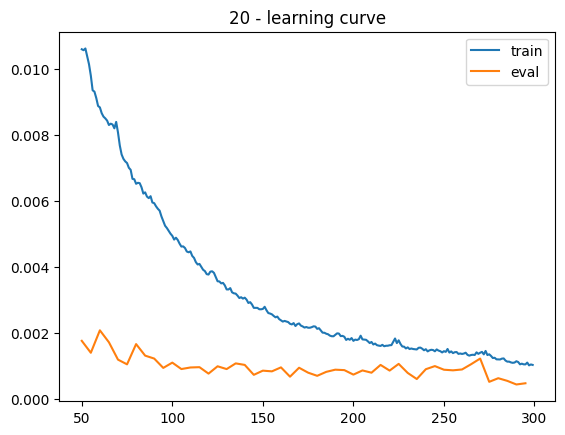

600
120


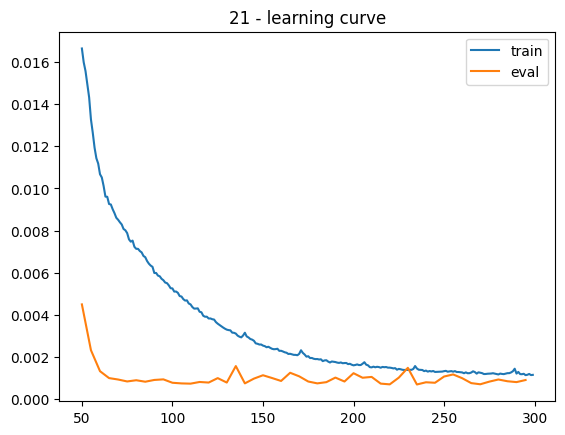

600
120


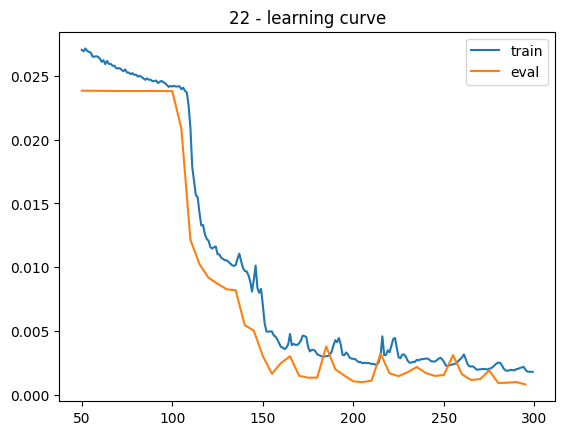

600
120


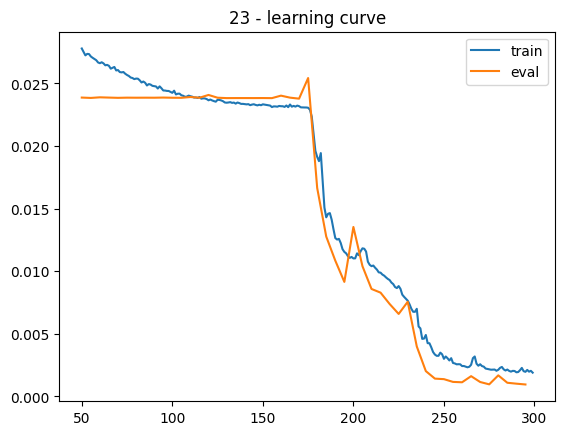

In [42]:
evaluator.plot_learning_curves(50, 300, 5)

In [27]:
evaluator.generate_evaluation_table()

,mse,rmse,mae
0,0.000037,0.006084,0.002175
1,0.000057,0.007554,0.003069
2,0.000547,0.023379,0.008592
3,0.000528,0.022980,0.007798
4,0.000078,0.008851,0.003549
5,0.000073,0.008568,0.003557
6,0.000708,0.026602,0.010203
7,0.000510,0.022593,0.007474
8,0.000257,0.016035,0.005278
9,0.000064,0.008009,0.002778
